In [1]:
from PathLoader import PathLoader

path_loader = PathLoader('data_config.env', 'current_user.env')

### Load data

import pandas as pd
import pickle

print('Loading data from biomarker data repository..')
# import GDSC2 drug response data using pickle

with open(f'{path_loader.get_data_path()}data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)
    
# import CCLE gene expression data using pickle

with open(f'{path_loader.get_data_path()}data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open(f'{path_loader.get_data_path()}data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open(f'{path_loader.get_data_path()}data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open(f'{path_loader.get_data_path()}data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open(f'{path_loader.get_data_path()}data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open(f'{path_loader.get_data_path()}data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open(f'{path_loader.get_data_path()}data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)

Loading data from biomarker data repository..


In [2]:
## Single run analysis 
from toolkit import * 
import DataFunctions as utils

target_variable = "LN_IC50"

data_df = utils.create_joint_dataset_from_proteome_gdsc("Palbociclib", joined_sin_peptile_exclusion_matrix, gdsc2, drug_value=target_variable)
feature_data, label_data = utils.create_feature_and_label(data_df, label_name=target_variable)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
RNG_SEED = 0 
# step by step analysis of the pipeline, begin with train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1, random_state=RNG_SEED)



In [4]:
# step 1, removing features with low variance

from sklearn.feature_selection import VarianceThreshold

X_transformed, y_transformed = transform_impute_by_zero_to_min_uniform(X_train, y_train)

# debug feature selection
# print(X_transformed.shape, y_transformed.shape)


# removing features with zero variance to avoid division by zero in f_regression
threshold_selector = VarianceThreshold(threshold=0.0)
threshold_selector.fit(X_transformed)
threshold_columns = X_transformed.columns[threshold_selector.get_support()]
X_transformed = X_transformed[threshold_columns]

In [5]:
# find columns that are not selected by the threshold selector

removed_columns = X_train.columns.difference(X_transformed.columns)

print(removed_columns.shape)
print(list(removed_columns))

(10,)
['P00439;PH4H_HUMAN', 'P01266;THYG_HUMAN', 'P05108;CP11A_HUMAN', 'P07202;PERT_HUMAN', 'P09923;PPBI_HUMAN', 'P35713;SOX18_HUMAN', 'Q8WWA0;ITLN1_HUMAN', 'Q8WWU7;ITLN2_HUMAN', 'Q8WYN0;ATG4A_HUMAN', 'Q9P1W8;SIRPG_HUMAN']


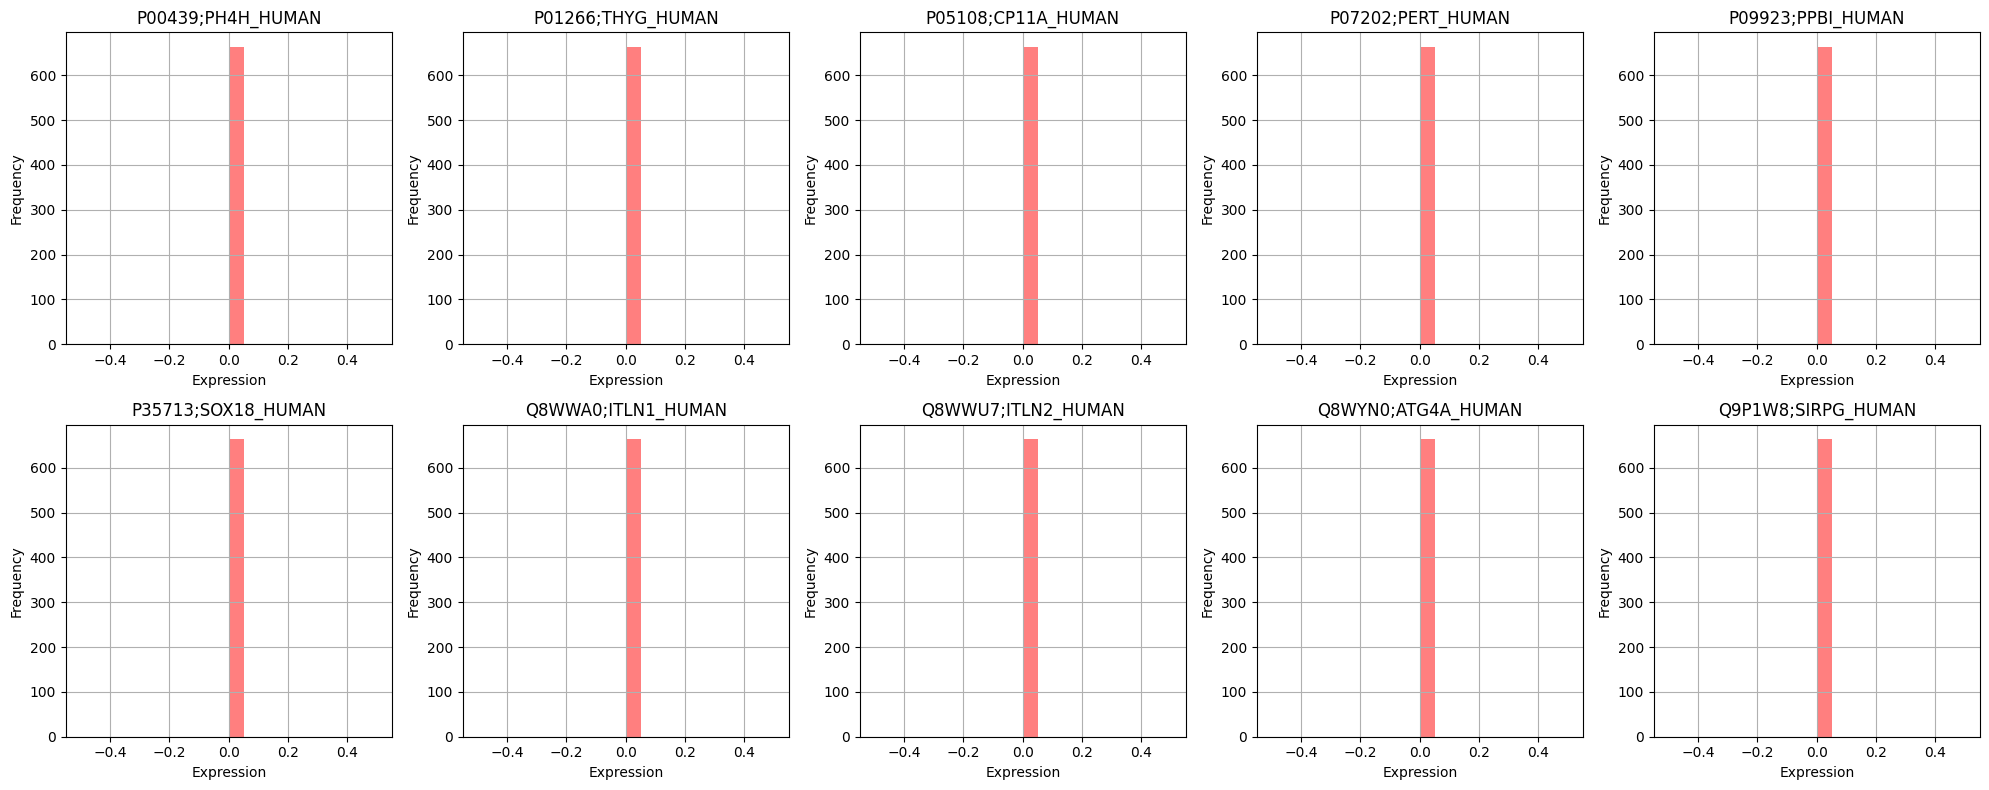

In [6]:
# plot the distribution of the removed columns

import Visualisation as viz
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, col in enumerate(removed_columns):
    X_train[col].plot(kind='hist', bins=20, ax=axes[i], color='red', alpha=0.5)
    axes[i].grid()
    axes[i].set_title(col)
    axes[i].set_xlabel('Expression')
plt.tight_layout()

In [7]:
selected_features, X_selected = f_regression_select(X_transformed, y_transformed, 10)

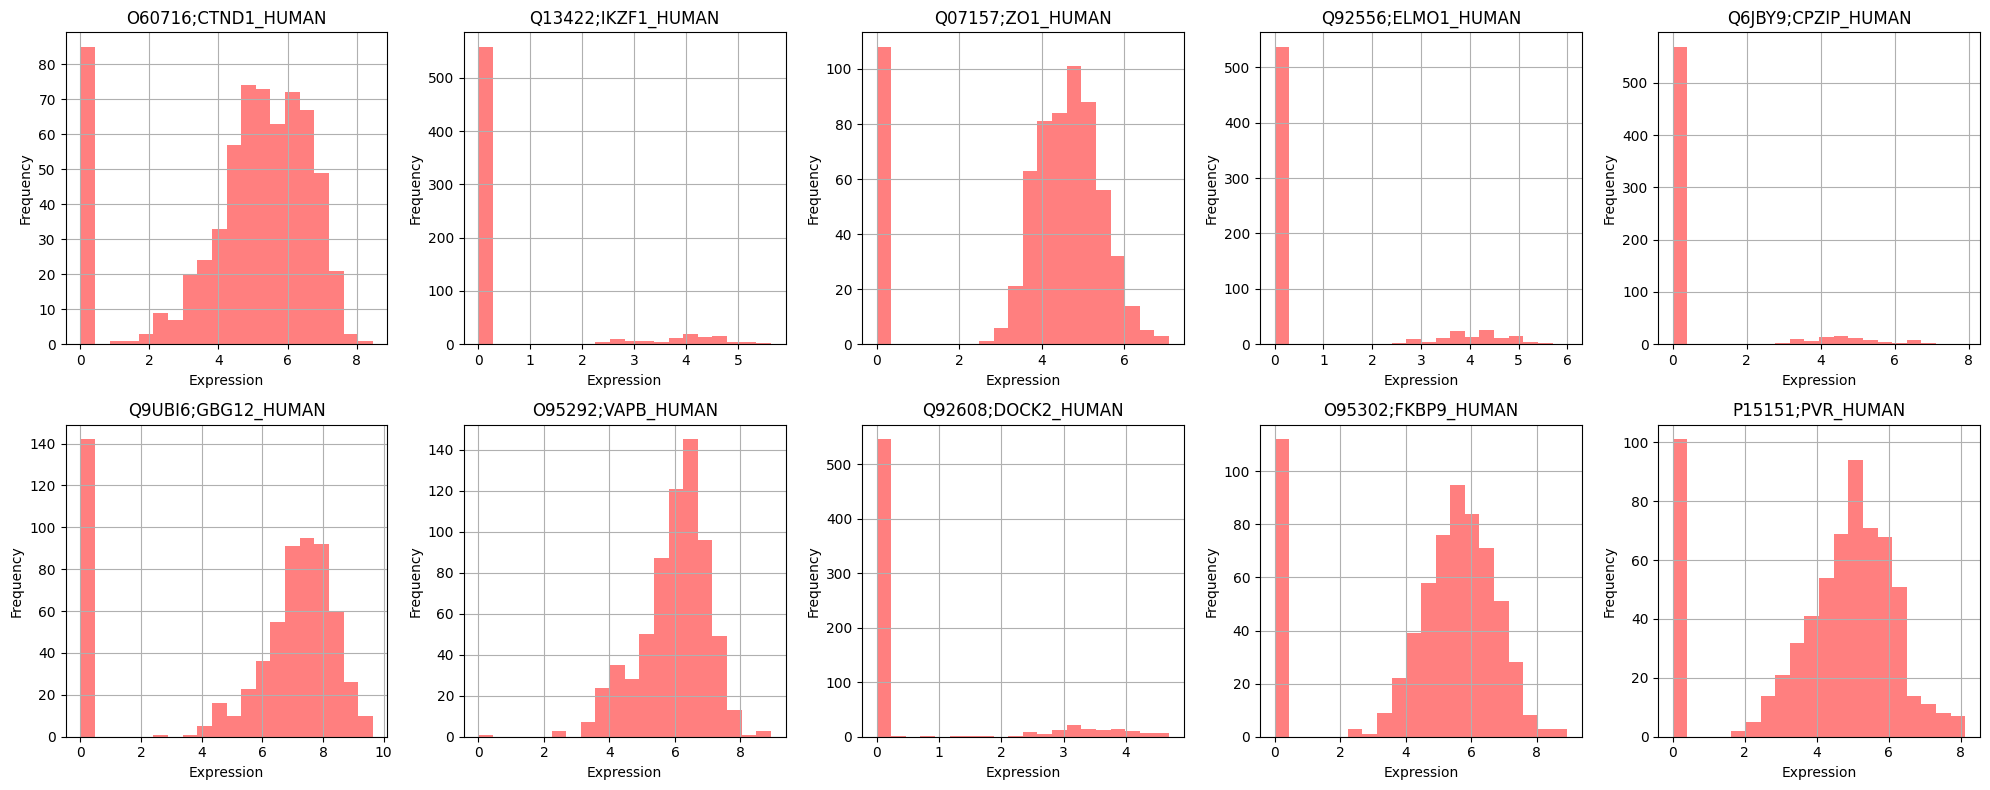

In [8]:
import Visualisation as viz
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, col in enumerate(selected_features):
    X_train[col].plot(kind='hist', bins=20, ax=axes[i], color='red', alpha=0.5)
    axes[i].grid()
    axes[i].set_title(col)
    axes[i].set_xlabel('Expression')
plt.tight_layout()

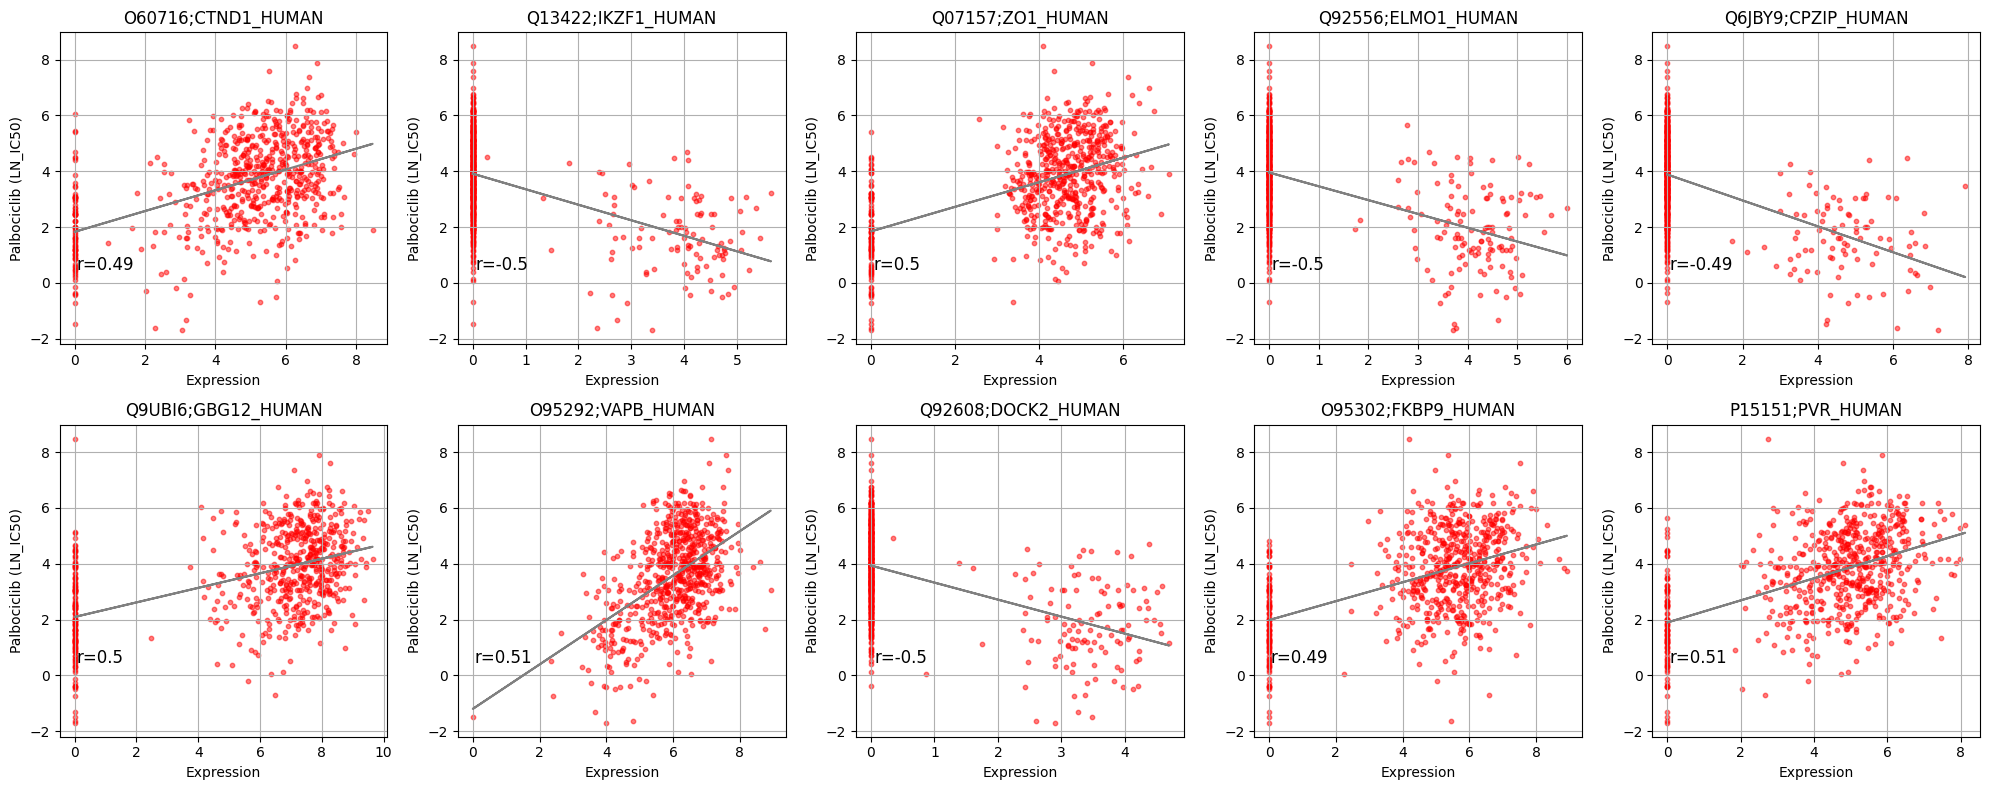

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, col in enumerate(selected_features):
    # plot correlation
    X = X_train[col]
    Y = y_train
    axes[i].scatter(X, Y, color='red', alpha=0.5, s=10)
    m, b = np.polyfit(X, Y, 1)
    axes[i].plot(X, m*X + b, color='grey')
    corr = str(round(np.corrcoef(X, Y)[0, 1], 2))

    # insert annotations
    axes[i].grid()
    axes[i].text(0.05, 0.95, f'r={corr}', fontsize=12, verticalalignment='top')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Expression')
    axes[i].set_ylabel('Palbociclib (LN_IC50)')

plt.tight_layout()
plt.show()




In [21]:
selected_features, selected_feature_scores = f_regression_select(X_transformed, y_transformed, 100)

_, X_selected = select_preset_features(X_transformed, y_transformed, selected_features)

In [22]:
ht_best_params, ht_best_fit_score, ht_results = hypertune_svr(X_selected, y_transformed, cv=5)


In [23]:
ht_results

{'mean_fit_time': array([1.24906092, 0.02709727, 0.0197031 , 0.02739959]),
 'std_fit_time': array([0.26962517, 0.00321668, 0.00196697, 0.00216137]),
 'mean_score_time': array([0.00488825, 0.00509686, 0.01395469, 0.00501227]),
 'std_score_time': array([0.00210743, 0.00339403, 0.00237557, 0.00268252]),
 'param_kernel': masked_array(data=['linear', 'poly', 'rbf', 'sigmoid'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 'linear'},
  {'kernel': 'poly'},
  {'kernel': 'rbf'},
  {'kernel': 'sigmoid'}],
 'split0_test_score': array([ 0.24820571,  0.27719047,  0.31135069, -0.53786286]),
 'split1_test_score': array([ 0.41702803,  0.43241531,  0.46467639, -0.12798351]),
 'split2_test_score': array([ 0.12533446,  0.2921229 ,  0.39988985, -0.53930563]),
 'split3_test_score': array([ 0.33125702,  0.37400422,  0.42271019, -0.44160476]),
 'split4_test_score': array([ 0.02104169,  0.25867035,  0.31209794, -0.32654249]),
 'mean

In [24]:
ht_best_params

{'kernel': 'rbf'}

In [25]:
tuned_model = SVR(**ht_best_params)


In [26]:
# given selected_features and scores, select the highest scoring features
hi_feature = selected_features[np.argmax(selected_feature_scores)]
print(f'First feature selected: {hi_feature}, score: {np.max(selected_feature_scores)}')
# use wrapper method to select features
wrapper_features, wrapper_scores = greedy_feedforward_select(X_selected, y_transformed, 10, tuned_model, 
                                                                start_feature=hi_feature,cv=5, verbose=1)

First feature selected: P15151;PVR_HUMAN, score: 230.36299048512137
Feature Selected: O95292;VAPB_HUMAN, Score: 0.3084743502855787, Feature Size: 2
Feature Selected: Q6WCQ1;MPRIP_HUMAN, Score: 0.344945653523788, Feature Size: 3
Feature Selected: Q9UHQ9;NB5R1_HUMAN, Score: 0.3655780613703209, Feature Size: 4
Feature Selected: Q14761;PTCA_HUMAN, Score: 0.37369835234180604, Feature Size: 5
Feature Selected: P06400;RB_HUMAN, Score: 0.37938749594647536, Feature Size: 6
Feature Selected: Q9UQB8;BAIP2_HUMAN, Score: 0.38735434584456085, Feature Size: 7
Feature Selected: Q9Y5B0;CTDP1_HUMAN, Score: 0.3927989654708871, Feature Size: 8
Feature Selected: P10301;RRAS_HUMAN, Score: 0.4004354620431898, Feature Size: 9
Feature Selected: Q86YV0;RASL3_HUMAN, Score: 0.4009468843747864, Feature Size: 10


using the performance as score for the wrapper method was an error. The first selected feature is always of low score and of course will return a high count. 

In [29]:
_, X_test_selected = select_preset_features(X_test, y_test, wrapper_features)

y_pred = tuned_model.fit(X_selected[wrapper_features], y_transformed).predict(X_test_selected)



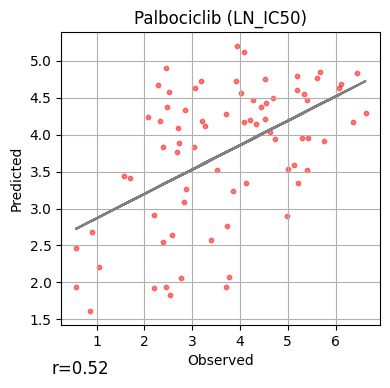

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(y_test, y_pred, color='red', alpha=0.5, s=10)
m, b = np.polyfit(y_test, y_pred, 1)
ax.plot(y_test, m*y_test + b, color='grey')
corr = str(round(np.corrcoef(y_test, y_pred)[0, 1], 2))

# insert annotations
ax.grid()
ax.text(0.05, 0.95, f'r={corr}', fontsize=12, verticalalignment='top')
ax.set_title(f'Palbociclib (LN_IC50)')
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

